In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors

import dateutil.parser

In [2]:
def time_converter(data, minute=False):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    if minute == True:
        return (d*24 + h)*60 + m + s/60
    return ((d*24 + h)*60+m)*60+s

In [18]:
def memory_size_converter(size):
    giga = True
    if 'M' in size:
        giga = False
    num = float(size.rstrip('MnGc'))
    if giga:
        return num*1024
    return num

In [11]:
accre_node_mem = np.array([48, 64, 96, 128, 256]) * 1024
accre_node_mem

array([ 49152,  65536,  98304, 131072, 262144])

In [8]:
df = pd.read_csv('accre_slurm_request_info.csv', delimiter="|")

In [9]:
df.head()

,Submission,Start,Stop,State,NNodes,NCpus,ReqMem,ReqTime,NodeList
0,2017-12-24T12:04:39,2017-12-25T14:23:37,2017-12-26T17:27:47,COMPLETED,2,1,40000Mn,4-00:00:00,vmp222
1,2017-12-24T13:04:36,2017-12-25T14:29:44,2017-12-26T02:44:26,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1308
2,2017-12-24T13:04:37,2017-12-25T14:56:44,2017-12-26T17:46:46,COMPLETED,2,1,40000Mn,4-00:00:00,vmp238
3,2017-12-24T13:04:39,2017-12-25T15:05:35,2017-12-26T02:49:42,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1368
4,2017-12-24T13:04:39,2017-12-25T15:07:56,2017-12-26T01:22:02,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1301


In [10]:
df['Timelimit_num'] = df['ReqTime'].astype(str)
df['Timelimit_num'] = df.Timelimit_num.apply(time_converter)

In [13]:
def datetime_to_minutes(d):
    return d.seconds/60

df['Start_dt'] = df.Start.apply(dateutil.parser.parse)
df['Submit_dt'] = df.Submission.apply(dateutil.parser.parse)
df["WaitTime(min)"] = df['Start_dt'] - df['Submit_dt']
df['WaitTime(min)'] = df["WaitTime(min)"].apply(datetime_to_minutes)

In [19]:
df['ReqMem_num'] = df.ReqMem.apply(memory_size_converter)

In [20]:
df.head()

,Submission,Start,Stop,State,NNodes,NCpus,ReqMem,ReqTime,NodeList,Timelimit_num,Start_dt,Submit_dt,WaitTime(min),ReqMem_num
0,2017-12-24T12:04:39,2017-12-25T14:23:37,2017-12-26T17:27:47,COMPLETED,2,1,40000Mn,4-00:00:00,vmp222,345600,2017-12-25 14:23:37,2017-12-24 12:04:39,138.966667,40000.0
1,2017-12-24T13:04:36,2017-12-25T14:29:44,2017-12-26T02:44:26,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1308,345600,2017-12-25 14:29:44,2017-12-24 13:04:36,85.133333,40000.0
2,2017-12-24T13:04:37,2017-12-25T14:56:44,2017-12-26T17:46:46,COMPLETED,2,1,40000Mn,4-00:00:00,vmp238,345600,2017-12-25 14:56:44,2017-12-24 13:04:37,112.116667,40000.0
3,2017-12-24T13:04:39,2017-12-25T15:05:35,2017-12-26T02:49:42,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1368,345600,2017-12-25 15:05:35,2017-12-24 13:04:39,120.933333,40000.0
4,2017-12-24T13:04:39,2017-12-25T15:07:56,2017-12-26T01:22:02,COMPLETED,2,1,40000Mn,4-00:00:00,vmp1301,345600,2017-12-25 15:07:56,2017-12-24 13:04:39,123.283333,40000.0


# Plot wait time to requested memory

In [36]:
# only keep entries that ran over one hour
df = df[df.Timelimit_num > 3600]
# only keep entries that request over 1 GB
df = df[df.ReqMem_num > 1024]
len(df)

2367739

### Create bins of memory / time requests

In [38]:
print("Min Walltime %.2f" %(df["Timelimit_num"].min()/60))
print("Max Walltime %.2f" %(df["Timelimit_num"].max()/60))

Min Walltime 61.00
Max Walltime 20160.00


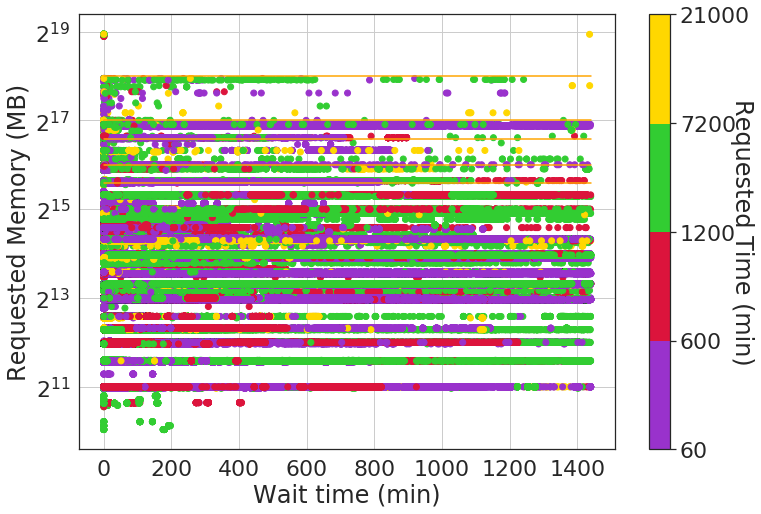

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

bounds = [60, 600, 1200, 7200, 21000]
colors = ["darkorchid", "crimson", "limegreen", "gold"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

sc = ax.scatter(df["WaitTime(min)"], df.ReqMem_num,
                c=df.Timelimit_num.values/60, cmap=cmap, norm=norm)

# set the ACCRE resources
for i in accre_node_mem:
    plt.plot([0, df["WaitTime(min)"].max()], [i, i], color='orange')

cbar = fig.colorbar(sc, spacing="uniform")
cbar.ax.set_ylabel('Requested Time (min)', rotation=270)

plt.grid(True)
ax.set_xlabel('Wait time (min)')
ax.set_ylabel('Requested Memory (MB)')

ax.set_yscale('log', basey=2)
plt.savefig("figures/wait_time_memory_all.png")
plt.show()

In [40]:
print("Min Reg Memory %.2f" %(df["ReqMem_num"].min()))
print("Max Reg Memory %.2f" %(df["ReqMem_num"].max()))

Min Reg Memory 1052.00
Max Reg Memory 502784.00


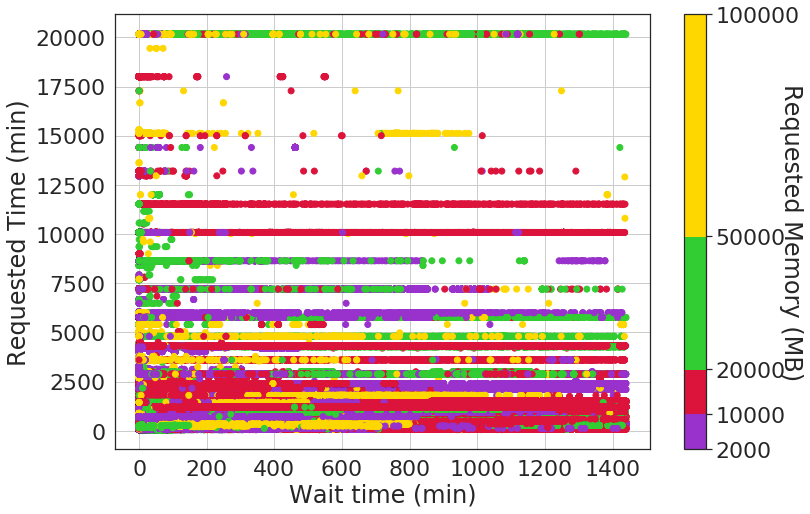

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")

bounds = [2000, 10000, 20000, 50000, 100000]
colors = ["darkorchid", "crimson", "limegreen", "gold"]
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, len(colors))

sc = ax.scatter(df["WaitTime(min)"], df.Timelimit_num/60,
                c=df.ReqMem_num.values, cmap=cmap, norm=norm)

cbar = fig.colorbar(sc, spacing="proportional")
cbar.ax.set_ylabel('Requested Memory (MB)', rotation=270)

plt.grid(True)
ax.set_xlabel('Wait time (min)')
ax.set_ylabel('Requested Time (min)')

plt.savefig("figures/wait_time_walltime_all.png")
plt.show()